<a href="https://colab.research.google.com/github/egorssed/Simulation-based_Inference/blob/master/Notebooks/colab/Deeplenstronomy_SLACS_like_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install sbi --quiet
!pip install deeplenstronomy==0.0.2.0 --quiet
!pip install lenstronomy --quiet
!pip install deeplenstronomy --quiet
#!pip install getdist --quiet

#we also do this because of some compatibility issues with SBI
!pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

!pip install git+https://github.com/sibirrer/fastell4py.git


# import main simulation class of lenstronomy
import deeplenstronomy.deeplenstronomy as dl
from deeplenstronomy.visualize import view_image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import os, sys
from google.colab import drive
# Change to mount '/content/drive/My Drive/Fermilab/'
drive.mount('/content/drive')
Folder='/content/drive/MyDrive/Fermilab/'

     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 829 kB 15.1 MB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 
     |████████████████████████████████| 3.4 MB 43.7 MB/s 
     |████████████████████████████████| 11.2 MB 17.6 MB/s 
     |████████████████████████████████| 895 kB 52.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Successfully uninstalled matplotlib-3.5.1
     |████████████████████████████████| 13.1 MB 7.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

  Cloning https://github.com/sibirrer/fastell4py.git to /tmp/pip-req-build-nrcl3cze
  Running command git clone -q https://github.com/sibirrer/fastell4py.git /tmp/pip-req-build-nrcl3cze
  Created wheel for fastell4py: filename=fastell4py-0.1.0-cp37-cp37m-linux_x86_64.whl size=205876 sha256=1eddf2f8b1c2bd6c091e77a32907eef88e29ad071c897ab1c56b1c7e59ccbedb
  Stored in directory: /tmp/pip-ephem-wheel-cache-1l_2dik9/wheels/1c/f6/b7/0949bea0537d786e3bd69db6e13e8cd4e4e737437cfad37874
Successfully built fastell4py
Mounted at /content/drive


# Test functionality of deeplenstronomy

In [2]:
path_Config=Folder+'Data/Config_files_SLACS_alike/'
dataset_Park_SLACS=dl.make_dataset(path_Config+'Lenses_Park2021_HST.yaml',return_planes=True)
data_images=dataset_Park_SLACS.CONFIGURATION_1_images[:,0]
data_lens_lights=dataset_Park_SLACS.CONFIGURATION_1_planes[:,0,0]
data_source_lights=dataset_Park_SLACS.CONFIGURATION_1_planes[:,1,0]
data_noise=data_images-data_lens_lights-data_source_lights

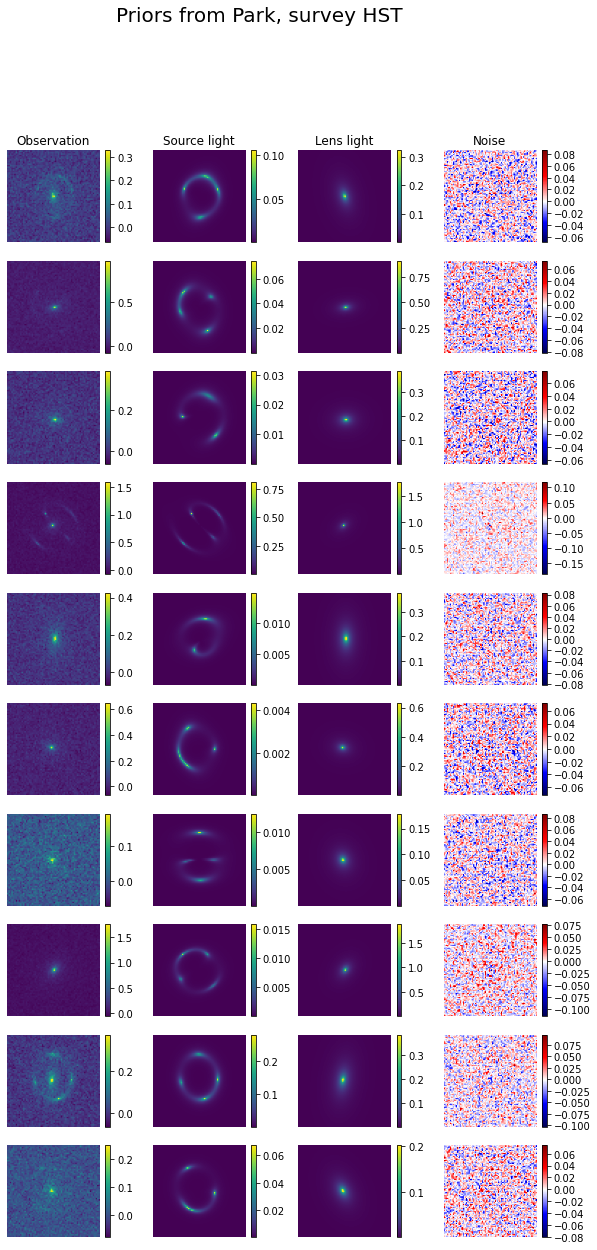

In [3]:
fig,ax=plt.subplots(10,4,figsize=(10,20))

for i in range(10):
  img_arr=[]
  img_arr+=[ax[i,0].imshow(data_images[i])]
  img_arr+=[ax[i,1].imshow(data_source_lights[i])]
  img_arr+=[ax[i,2].imshow(data_lens_lights[i])]
  img_arr+=[ax[i,3].imshow(data_noise[i],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
  for j in range(4):
    ax[i,j].axis('off')
    fig.colorbar(img_arr[j],ax=ax[i,j],fraction=0.045)

ax[0,0].set_title('Observation')
ax[0,1].set_title('Source light')
ax[0,2].set_title('Lens light')
ax[0,3].set_title('Noise')

fig.suptitle('Priors from Park, survey HST',fontsize=20)
plt.show()

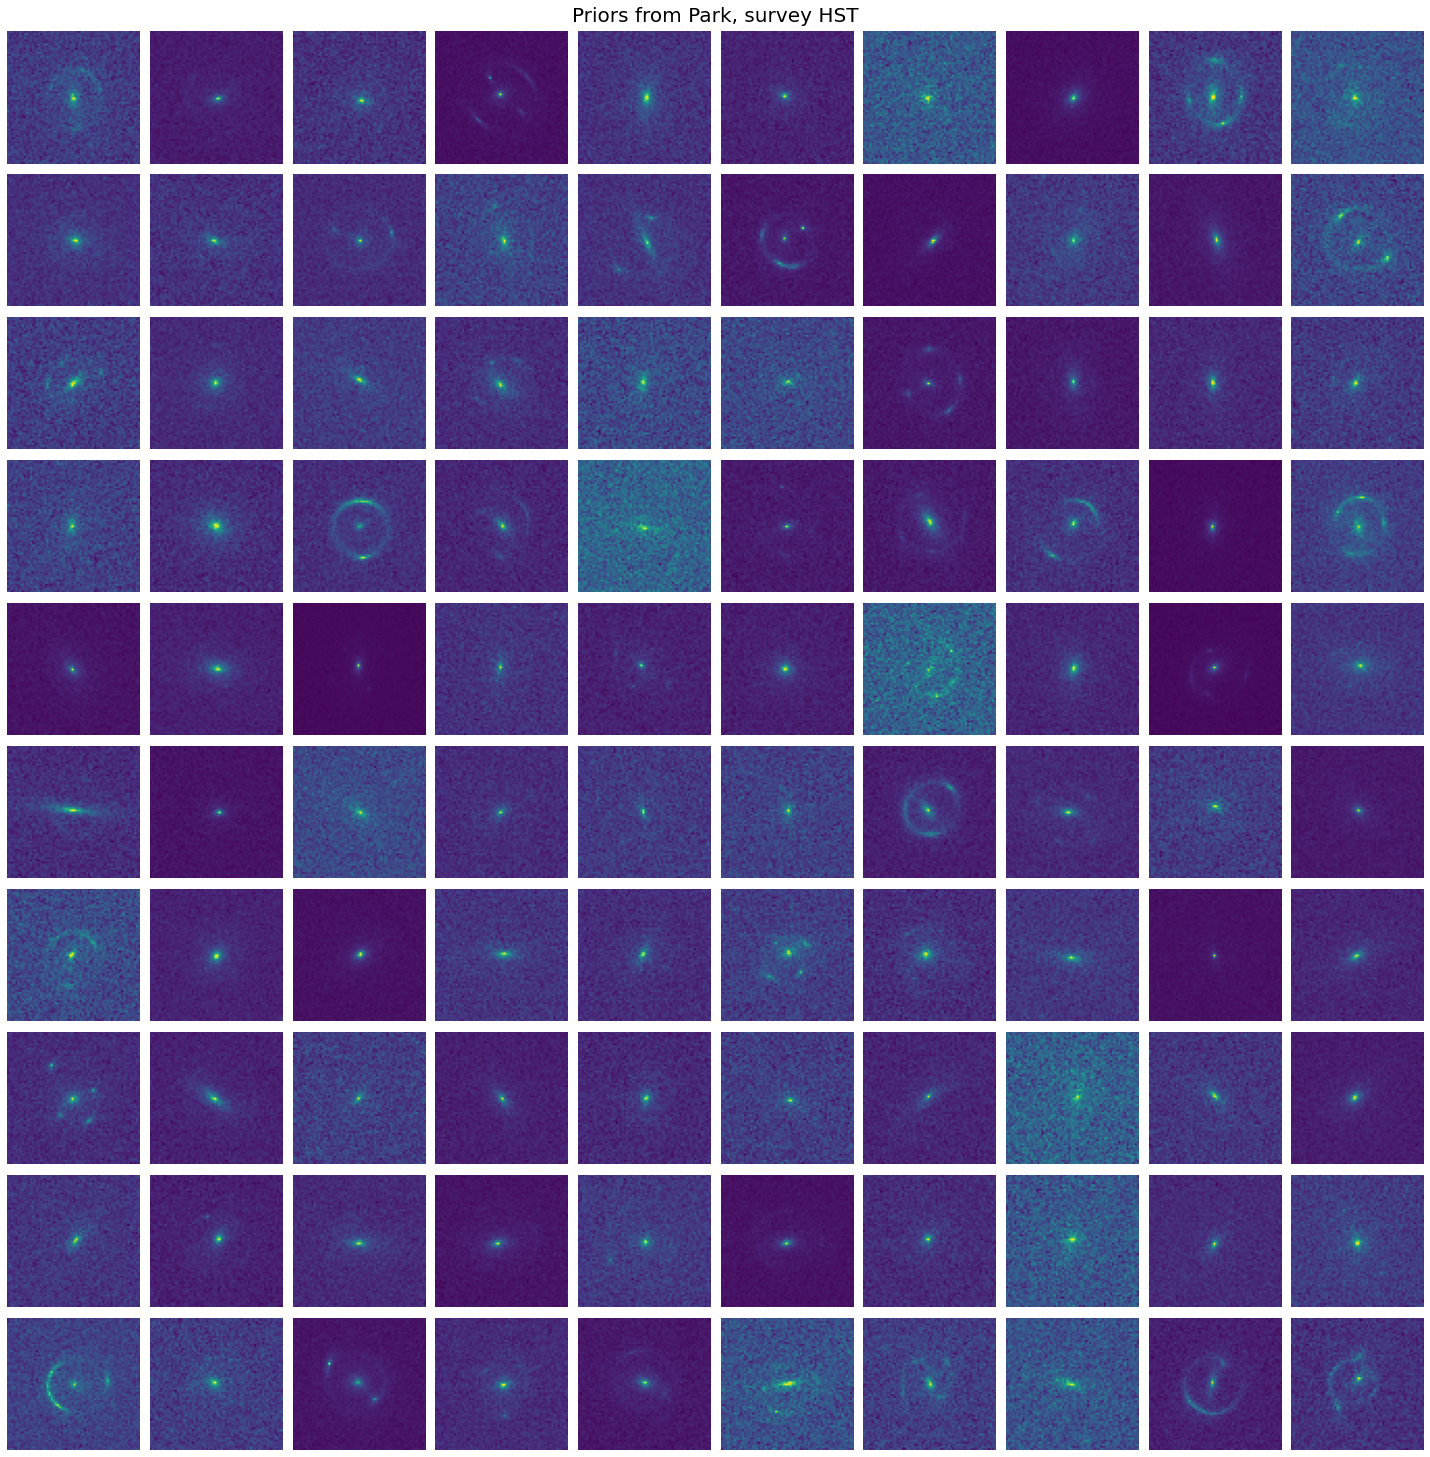

In [4]:
fig,ax=plt.subplots(10,10,figsize=(20,20))

for i in range(10):
    for j in range(10):
        ax[i,j].imshow(data_images[i*10+j])
        ax[i,j].axis('off')

fig.suptitle('Priors from Park, survey HST',fontsize=20,y=1.01)
plt.tight_layout()
plt.show()

Above SNR: 648
Number of images: 1000


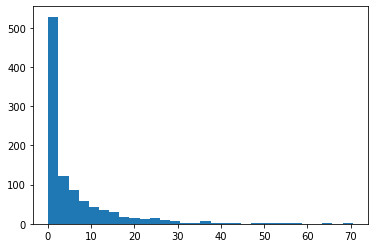

In [5]:
SNRs=data_source_lights.max(axis=(1,2))/data_noise.std(axis=(1,2))
plt.hist(SNRs,bins=30)
print('Above SNR: %d'%((SNRs>1).sum()))
print('Number of images: %d'%(len(SNRs)))
plt.show()

In [ ]:
data_source_lights_masks=np.array([(data_source_lights[i]>data_noise[i].std()).astype(int) for i in range(len(data_source_lights))])
data_lens_lights_masks=np.array([2*(data_lens_lights[i]>data_noise[i].std()).astype(int) for i in range(len(data_lens_lights))])

data_images_masks=data_source_lights_masks+data_lens_lights_masks
# Correct for intersection
data_images_masks[data_images_masks==3]=2

# Generate dataset

In [ ]:
# TODO: find in MRCNN.utils what shape should have mask for several classes 

In [6]:
path_Config=Folder+'Data/Config_files_SLACS_alike/'

data_images=np.zeros((10000,64,64,1))
data_masks=np.zeros((10000,64,64,2))

i=0
sample_size=1000
# We need to use while loop, cuase if make_dataset samples shit it just raises error
while i<10:
  try:
    print(i)
    dataset_sample=dl.make_dataset(path_Config+'Lenses_Park2021_HST.yaml',return_planes=True)
    mock_images=dataset_sample.CONFIGURATION_1_images[:,0,:,:]
    
    lens_lights=dataset_sample.CONFIGURATION_1_planes[:,0,0]
    source_lights=dataset_sample.CONFIGURATION_1_planes[:,1,0]
    noise_images=mock_images-lens_lights-source_lights

    # Mask regions with SNR>0
    lens_masks=np.array([(lens_lights[i]>noise_images[i].std()).astype(int) for i in range(len(lens_lights))])
    source_masks=np.array([(source_lights[i]>noise_images[i].std()).astype(int) for i in range(len(source_lights))])

    data_images[i*sample_size:(i+1)*sample_size,:,:,0]=mock_images
    data_masks[i*sample_size:(i+1)*sample_size,:,:,0]=source_masks
    data_masks[i*sample_size:(i+1)*sample_size,:,:,1]=lens_masks
    i+=1
  except:
    continue

0
1
2
3
4
5
6
7
8
9


In [7]:
#np.savez('/content/drive/MyDrive/Fermilab/Data/Dataset_SLACS_alike/dataset',images=data_images,masks=data_masks)